In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report,confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Dataset/Copy of KDDTrain+.txt', header=None)
test = pd.read_csv('/content/drive/MyDrive/Dataset/Copy of KDDTest+.txt', header =None)
train

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [ ]:
train.iloc[:,41].value_counts(dropna=False)

41
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

In [ ]:
test.iloc[:,41].value_counts(dropna=False)

41
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
loadmodule            2
perl                  2
sqlattack             2
udpstorm              2
phf                   2
imap                  1
Name: count, dtype: int64

In [ ]:
train['target'] = train.iloc[:,41].apply(lambda x: 0 if x == 'normal' else 1)
test['target'] = test.iloc[:,41].apply(lambda x: 0 if x == 'normal' else 1)
data = train['target'].value_counts()
lab = ['normal','attack']

data

target
0    67343
1    58630
Name: count, dtype: int64

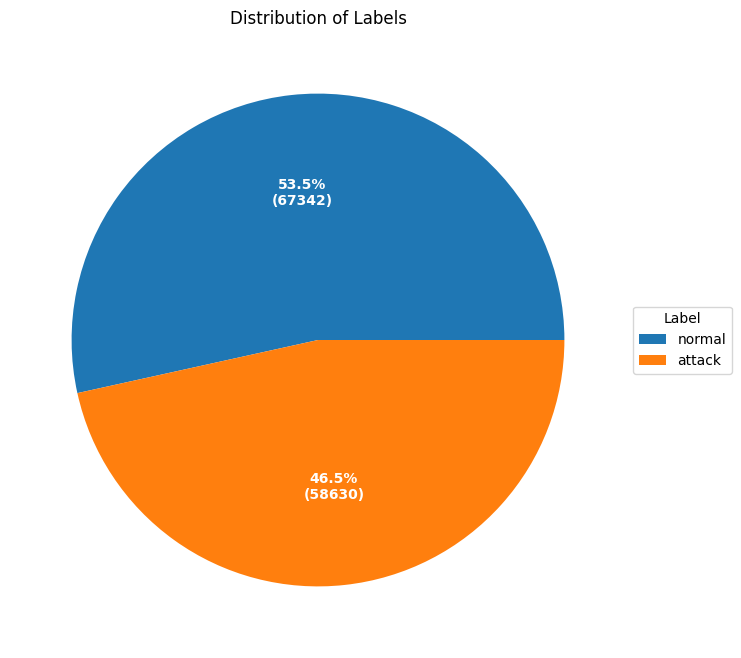

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, lab,
          title="Label",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=10, weight="bold")

ax.set_title("Distribution of Labels")

plt.show()

In [ ]:
DOS = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','upstorm','worm']
Probe = ['ipsweep','nmap','mscan','portsweep','saint','satan']
U2R = ['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm']
R2L = ['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','Snmpgetattack','spy','snmpguess','warzclient','warzmaster','xlock','xsnoop']
count = {'DOS':0, 'Probe':0, 'U2R':0, 'R2L':0}
for attack in train[41]:
    if attack in DOS:
        count['DOS'] += 1
    elif attack in Probe:
        count['Probe'] += 1
    elif attack in U2R:
        count['U2R'] += 1
    elif attack in R2L:
        count['R2L'] += 1
count

# \*{'DOS': 53385, 'Probe': 14077, 'R2L': 1848, 'U2R': 119}*/

{'DOS': 45927, 'Probe': 11656, 'U2R': 52, 'R2L': 85}

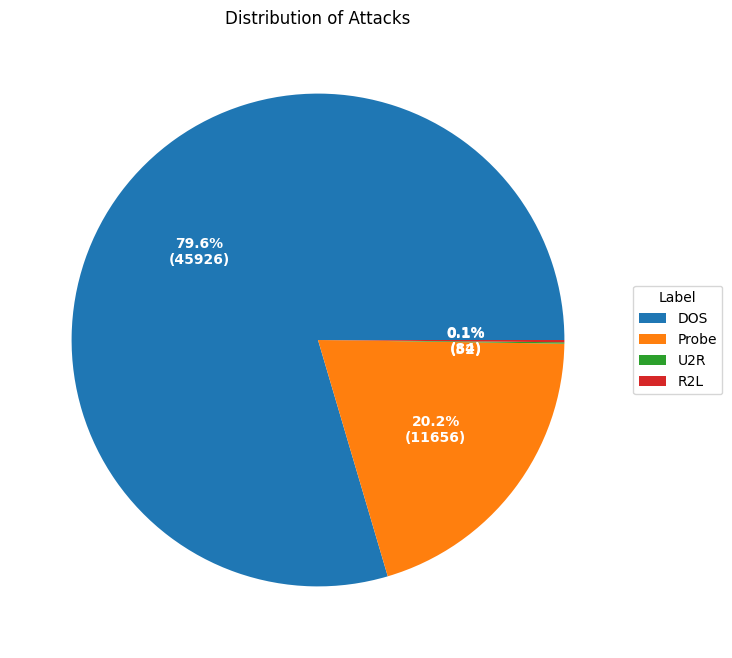

[45927, 11656, 52, 85]

In [ ]:
data = list(count.values())
lab = list(count.keys())
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, lab,
          title="Label",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=10, weight="bold")

ax.set_title("Distribution of Attacks")

plt.show()
data

In [ ]:
train.drop(columns=[41,42], inplace=True)
test.drop(columns=[41,42], inplace=True)
train

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,target
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,1
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,0
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1


In [ ]:
categorical = [1,2,3]

encoder = LabelEncoder()
for col in categorical:
    train.iloc[:,col] = pd.Series(encoder.fit_transform(train.iloc[:,col]))
    test.iloc[:,col] = pd.Series(encoder.transform(test.iloc[:,col]))

In [ ]:
train = pd.concat([train,test],axis=0)

X = train.drop(columns='target',axis=1)
y = train.target

scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X))

X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,random_state=10)

RANDOM FOREST CLASSIFIER

In [ ]:
rf_mod = RandomForestClassifier(n_estimators=200, criterion='entropy',
                                random_state= 10, verbose= 1)
rf_mod.fit(X_train, y_train)

print("Train score: ",rf_mod.score(X_train, y_train))

pred_rf = rf_mod.predict(X_test)
print('Test score:',rf_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_rf,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_rf))
print("Average weighted recall: ",recall_score(y_test,pred_rf))
print("Average weighted f1 score: ",f1_score(y_test,pred_rf))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   21.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.8s


Train score:  0.9994703152073402


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.4s


Test score: 0.9954214920549421
Classification report:                precision    recall  f1-score   support

           0       1.00      0.99      1.00     19264
           1       0.99      1.00      1.00     17866

    accuracy                           1.00     37130
   macro avg       1.00      1.00      1.00     37130
weighted avg       1.00      1.00      1.00     37130

Average weighted precision:  0.9961938878316355
Average weighted recall:  0.9943016759776536
Average weighted f1 score:  0.9952468825141195


NAIVE BAYES CLASSIFIER

In [ ]:
gnb_mod = GaussianNB()
gnb_mod.fit(X_train, y_train)

print("Train score: ",gnb_mod.score(X_train, y_train))

pred_nb = gnb_mod.predict(X_test)
print('Test score:',gnb_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_nb,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_nb))
print("Average weighted recall: ",recall_score(y_test,pred_nb))
print("Average weighted f1 score: ",f1_score(y_test,pred_nb))

Train score:  0.8799680393582734
Test score: 0.8808241314301104
Classification report:                precision    recall  f1-score   support

           0       0.89      0.88      0.89     19399
           1       0.87      0.88      0.88     17731

    accuracy                           0.88     37130
   macro avg       0.88      0.88      0.88     37130
weighted avg       0.88      0.88      0.88     37130

Average weighted precision:  0.87998420844848
Average weighted recall:  0.8716759776536313
Average weighted f1 score:  0.8758103898290813


LOGISTIC REGRESSION

In [ ]:
lg_mod = LogisticRegression()
lg_mod.fit(X_train, y_train)

print("Train score: ",lg_mod.score(X_train, y_train))

pred_lg = lg_mod.predict(X_test)
print('Test score:',lg_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_lg,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_lg))
print("Average weighted recall: ",recall_score(y_test,pred_lg))
print("Average weighted f1 score: ",f1_score(y_test,pred_lg))

Train score:  0.9361954267553664
Test score: 0.9373552383517372
Classification report:                precision    recall  f1-score   support

           0       0.96      0.93      0.94     19840
           1       0.92      0.95      0.93     17290

    accuracy                           0.94     37130
   macro avg       0.94      0.94      0.94     37130
weighted avg       0.94      0.94      0.94     37130

Average weighted precision:  0.9503759398496241
Average weighted recall:  0.9179888268156424
Average weighted f1 score:  0.9339016766126741


SUPPORT VECTOR MACHINE

In [ ]:
svm_mod = SVC(probability=True)
svm_mod.fit(X_train, y_train)

print("Train score: ",svm_mod.score(X_train, y_train))

pred_svc = svm_mod.predict(X_test)
print('Test score:',svm_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_svc,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_svc))
print("Average weighted recall: ",recall_score(y_test,pred_svc))
print("Average weighted f1 score: ",f1_score(y_test,pred_svc))

Train score:  0.9836875039277474
Test score: 0.9828709938055481
Classification report:                precision    recall  f1-score   support

           0       0.99      0.98      0.98     19410
           1       0.98      0.99      0.98     17720

    accuracy                           0.98     37130
   macro avg       0.98      0.98      0.98     37130
weighted avg       0.98      0.98      0.98     37130

Average weighted precision:  0.9871331828442438
Average weighted recall:  0.9772067039106145
Average weighted f1 score:  0.9821448624368333


ROC Curve

No Skill AUC:  0.5


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.4s


RandomForest AUC:  0.999834521537286
Support Vector Machine AUC:  0.9973158051461722
Logistic Regression AUC:  0.9821765209155853
Gaussian Naive Bayes AUC:  0.9420016065447085


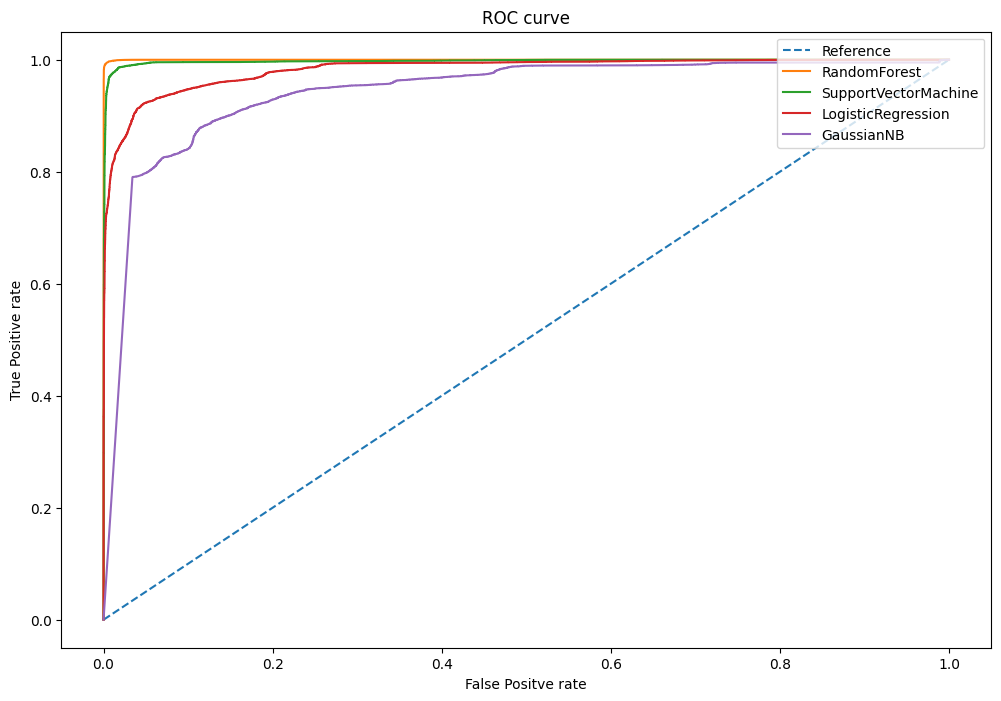

In [ ]:
no_skill_prob = [0 for _ in range(len(y_test))]
no_skill_auc = roc_auc_score(y_test, no_skill_prob)
print("No Skill AUC: ", no_skill_auc)
ns_fpr, ns_tpr, _ = roc_curve(y_test, no_skill_prob)

rf_prob = rf_mod.predict_proba(X_test)[:,-1]
rf_auc = roc_auc_score(y_test,rf_prob)
print("RandomForest AUC: ", rf_auc)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)

svm_prob = svm_mod.predict_proba(X_test)[:,-1]
svm_auc = roc_auc_score(y_test,svm_prob)
print("Support Vector Machine AUC: ", svm_auc)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_prob)

lg_prob = lg_mod.predict_proba(X_test)[:,-1]
lg_auc = roc_auc_score(y_test, lg_prob)
print("Logistic Regression AUC: ",lg_auc)
lg_fpr, lg_tpr, _ = roc_curve(y_test, lg_prob)

nb_prob = gnb_mod.predict_proba(X_test)[:,-1]
nb_auc = roc_auc_score(y_test, nb_prob)
print("Gaussian Naive Bayes AUC: ", nb_auc)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_prob)

fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(rf_fpr, rf_tpr, linestyle= '-', label= 'RandomForest')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')
ax.legend(loc="upper right")

ROC Curve (Zoomed on top left)

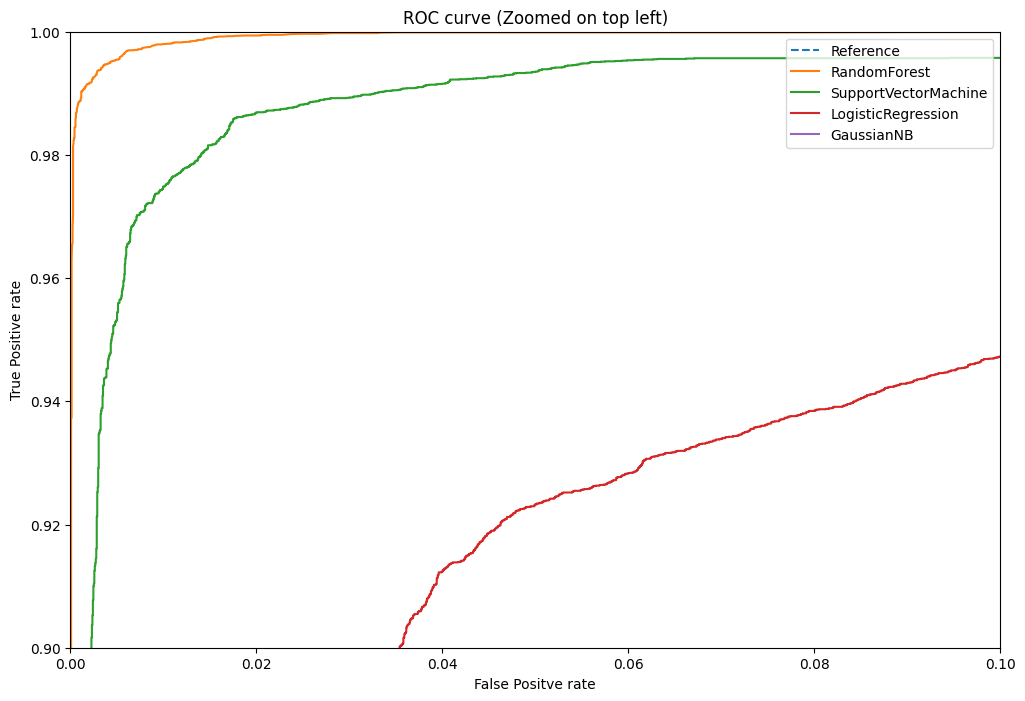

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(rf_fpr, rf_tpr, linestyle= '-', label= 'RandomForest')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve (Zoomed on top left)')
plt.xlim([0,0.1])
plt.ylim([0.9,1])
ax.legend(loc="upper right")

Calibration Curve

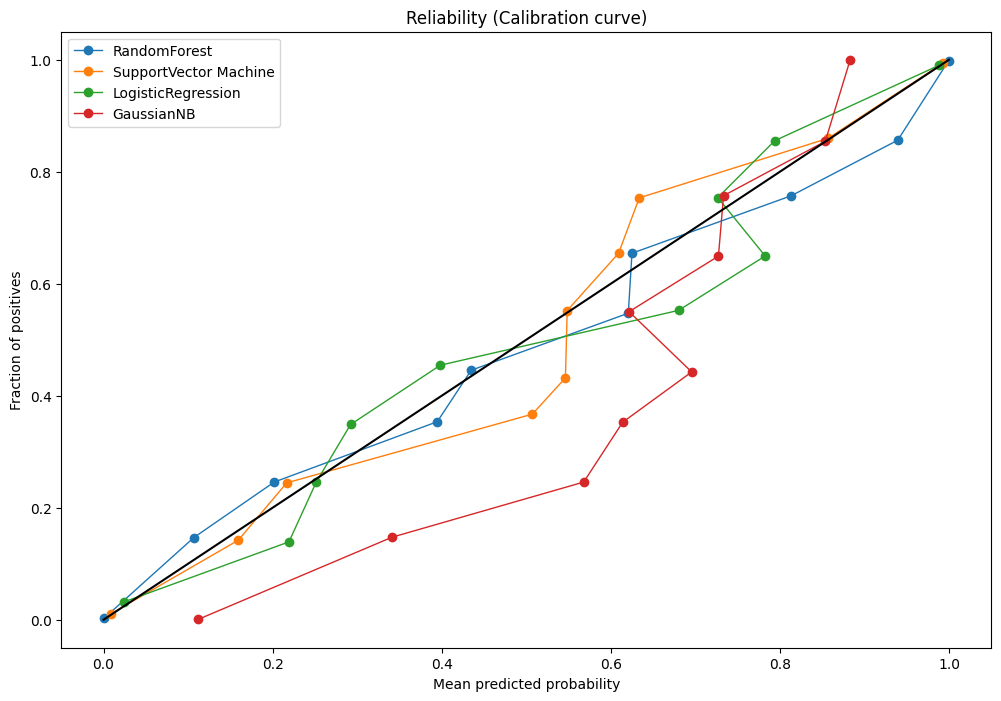

In [ ]:
rf_x, rf_y = calibration_curve(y_test, rf_prob, n_bins=10)
sv_x, sv_y = calibration_curve(y_test, svm_prob, n_bins=10)
lg_x, lg_y = calibration_curve(y_test, lg_prob, n_bins=10)
nb_x, nb_y = calibration_curve(y_test, nb_prob, n_bins=10)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(rf_x, rf_y, marker= 'o', linewidth= '1', label= 'RandomForest')
ax.plot(sv_x, sv_y, marker= 'o', linewidth= '1', label= 'SupportVector Machine')
ax.plot(lg_x, lg_y, marker= 'o', linewidth= '1', label= 'LogisticRegression')
ax.plot(nb_x, nb_y, marker= 'o', linewidth= '1', label= 'GaussianNB')

line = mlines.Line2D([0,1],[0,1], color='black')
ax.add_line(line)
ax.legend()
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability (Calibration curve)')
plt.show()

In [ ]:
models = {
    'Random Forest':rf_mod,
    'Support Vector Machine': svm_mod,
    'Logistic Regression':lg_mod,
    'Gaussian Naive Bayes': gnb_mod,
}

columns = [
    'accuracy',
    'precision',
    'recall',
    'f1'
]

table = {}


for model in models.keys():

    pred = models[model].predict(X_test)
    accuracy = models[model].score(X_test,y_test)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)

    table[model] = [accuracy, precision, recall, f1]

Model Comparison

In [ ]:
results = pd.DataFrame.from_dict(table, orient='index')
results.columns = columns
results